In [1]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
import ydf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import config  # Import the config file
import PreProc_Function as ppf
from imblearn.over_sampling import SMOTE

# For Future Use
#from sklearn.feature_selection import SelectKBest, f_classif
#from sklearn.model_selection import GridSearchCV

# Helper function to sort files by the numeric part in the filename
def sort_key(file_path):
    file_name = os.path.basename(file_path)
    numeric_part = ''.join(filter(str.isdigit, file_name))
    return int(numeric_part) if numeric_part else 0

def perform_evaluation_and_prediction(model, X_test, Folder, model_string, all_data, average_pre_proc_time, methods_string, learner, current_dir=os.getcwd()):
    
    print("\nModel Description:")
    describe = model.describe(output_format="notebook", full_details = True)
    print(describe)
    
    evaluation = model.evaluate(X_test)
    
    print(model.benchmark(X_test))

    print("\n")
    print('Test evaluation:')
    print(evaluation)

    test_loss = evaluation.loss       
    
    # Predict on the test set
    start_time_test_set = time.time()
    y_pred_probs = model.predict(X_test)
    end_time_test_set = time.time()
    
    # Convert labels to numpy array 
    y_test = X_test['label'].values
    
    #print("\nVariable importances keys:")
    #print(model.variable_importances().keys())
    
    print("\n10 most important features:")
    print(model.variable_importances()["SUM_SCORE"][:10])
    
    print("\n10 less important features:")
    print(model.variable_importances()["SUM_SCORE"][-10:])
    
    print("\nPredictions:")
    
    # Convert predicted probabilities to binary class labels
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    
    # Assuming y_pred_probs contains probabilities of being "Damaged Bearing"
    # 0 = Healthy Bearing, 1 = Damaged Bearing

    # Combine the true labels and predicted probabilities into a DataFrame
    probs_df = pd.DataFrame({
        'True Label': y_test.flatten(),  # Assuming y_test is the true binary labels array
        'Predicted Probability': y_pred_probs.flatten()
    })

    # Map the true labels to their corresponding names for better visualization
    probs_df['Label Name'] = probs_df['True Label'].map({0: 'Healthy Bearing', 1: 'Damaged Bearing'})

    # Set up the figure
    plt.figure(figsize=(12, 6))

    # Define a custom color palette with greenish for Healthy and reddish for Damaged
    palette = ['#66c2a5', '#fc8d62']  # Colors: greenish for Healthy, reddish for Damaged
    label_names = ['Healthy Bearing', 'Damaged Bearing']
    color_map = dict(zip(label_names, palette))

    # Plot histograms with KDE disabled for better control over KDE plots
    sns.histplot(data=probs_df, x='Predicted Probability', hue='Label Name', kde=False, bins=50, palette=color_map, alpha=0.4)

    # Plot KDE curves separately for each label to ensure correct color and labeling
    for label in label_names:
        sns.kdeplot(
            data=probs_df[probs_df['Label Name'] == label],
            x='Predicted Probability',
            color=color_map[label],
            label=f'{label} Curve',
            linewidth=2
        )

    # Customize the plot
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Probability Distribution for Healthy vs. Damaged Bearings')
    plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold (0.50)')
    # Place the legend inside the plot in the upper right
    plt.legend(title='True Label', loc='upper right')
    
    # Save the residual plot
    if(config.save_metrics):
        results_plot_folder = os.path.join(current_dir, 'DT_Results', 'IMPROVED_DATASET', Folder)
        results_plot_path = os.path.join(current_dir, 'DT_Results', 'IMPROVED_DATASET', Folder, model_string + '_plot_dist_' + methods_string + '.svg')
        os.makedirs(results_plot_folder, exist_ok=True)
        plt.savefig(results_plot_path, format='svg')

    plt.show()


    # Calculate additional metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_probs)

    # Count the number of good and damaged bearings in the test set
    unique, counts = np.unique(y_test, return_counts=True)
    label_counts = dict(zip(unique, counts))

    print(f"Number of good bearings (0) in the test set: {label_counts.get(0, 0)}")
    print(f"Number of damaged bearings (1) in the test set: {label_counts.get(1, 0)}")

    # Print the inference time
    inference_time = end_time_test_set - start_time_test_set
    average_inference_time = inference_time / len(y_test)
    print("\n")
    print("Time Metrics:")
    print(f"Average Pre-processing Time: {average_pre_proc_time:.4f} seconds")
    print(f"Inference Time: {inference_time:.4f} seconds")
    print(f"Average Inference Time: {average_inference_time:} seconds")

    print("\n")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f'Test Loss: {test_loss:.4f}') 
    
    print("\n")

    # Classification report
    print("Classification Report:")
    target_names = ['HEALTHY', 'DAMAGED']
    print(classification_report(y_test, y_pred, target_names=['DAMAGED', 'HEALTHY']))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    # Save the residual plot
    if(config.save_metrics):
        results_plot_folder = os.path.join(current_dir, 'DT_Results', 'IMPROVED_DATASET', Folder)
        results_plot_path = os.path.join(current_dir, 'DT_Results', 'IMPROVED_DATASET', Folder, model_string + '_conf_matrix_' + methods_string + '.svg')
        os.makedirs(results_plot_folder, exist_ok=True)
        plt.savefig(results_plot_path, format='svg')

    plt.show()

    # Save the classification report

    # Gather all metrics
    metrics_dict = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Loss',
                'Average Pre-processing Time','Average Inference Time'],
        'Value': [accuracy, precision, recall, f1, roc_auc,test_loss,
                average_pre_proc_time, average_inference_time]
    }
    # Save Metrics
    if(config.save_metrics):
        # Create DataFrame
        metrics_df = pd.DataFrame(metrics_dict)

        # Save DataFrame to CSV
        metrics_save_folder = os.path.join(current_dir, 'DT_Results', 'IMPROVED_DATASET', Folder)
        metrics_save_path = os.path.join(current_dir, 'DT_Results', 'IMPROVED_DATASET', Folder, model_string + '_metrics_' + methods_string + '.csv')
        os.makedirs(metrics_save_folder, exist_ok=True)
        metrics_df.to_csv(metrics_save_path, index=False)

        print("\nMetrics saved to CSV:")
        print(metrics_df)
        
    
    '''# Prediction with all data    
    cross_eval = learner.cross_validation(all_data, folds=10)
    
    print("\nCross Validation:")
    print(cross_eval)'''

    return evaluation

def extract_plot_data(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the script tag that contains the Plotly chart data
    script_tags = soup.find_all('script')
    script_text = [None, None]
    i = 0
    for script in script_tags:
        if(i == 2):
            break
        if 'Plotly.newPlot' in script.text:
            script_text[i] = script.text
            i += 1
    
    if not script_text:
        raise ValueError("No Plotly chart data found in the HTML content.")

    # Use regex to extract x and y values
    try:
        x_data = re.search(r"x:\s*\[([^\]]+)\]", script_text[0]).group(1)
        loss_data = re.findall(r"y:\s*\[([^\]]+)\]", script_text[0])
        accuracy_data = re.findall(r"y:\s*\[([^\]]+)\]", script_text[1])
        loss_training = loss_data[0]
        loss_validation = loss_data[1]
        accuracy_training = accuracy_data[0]
        accuracy_validation = accuracy_data[1]
    except (IndexError, AttributeError):
        raise ValueError("Error extracting plot data from the script text.")

    # Convert extracted data from strings to lists of floats
    x_values = list(map(float, x_data.split(',')))
    loss_training_values = list(map(float, loss_training.split(',')))
    loss_validation_values = list(map(float, loss_validation.split(',')))
    accuracy_training_values = list(map(float, accuracy_training.split(',')))
    accuracy_validation_values = list(map(float, accuracy_validation.split(',')))        

    return x_values, loss_training_values, loss_validation_values, accuracy_training_values, accuracy_validation_values


# Function to plot the extracted data using Plotly
def plot_from_html(html_content, save, save_path):
    # Extract the x and y data from the HTML
    x_values, loss_training_values, loss_validation_values, accuracy_training_values, accuracy_validation_values = extract_plot_data(html_content)

    # Plotting
    plt.figure(figsize=(10,6))
    plt.plot(x_values, loss_training_values, label='Training Loss', color='blue', linewidth=2)
    plt.plot(x_values, loss_validation_values, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.plot(x_values, accuracy_training_values, label='Training Accuracy', color='green', linewidth=2)
    plt.plot(x_values, accuracy_validation_values, label='Validation Accuracy', color='red', linestyle='--', linewidth=2)


    # Adding labels and title
    plt.xlabel('Number of Trees')
    plt.ylabel('Loss/Accuracy')
    plt.title('Training Metrics vs Validation Metrics')
    plt.legend()

    # Show plot
    plt.grid(True)
    if save:
        plt.savefig(save_path, format='svg')
    plt.show()
def read_data(csv_file_data, csv_file_labels):
    # Convert preprocessing options to a list of keywords to exclude if they are False
    exclude_keywords = [key for key, value in config.preprocessing_options.items() if not value]
    
    # Add "acc" and "gyr" to the exclusion list if 'sp_accel' is False
    if not config.preprocessing_options.get('sp_accel', True):
        exclude_keywords.extend(['acc', 'gyr'])
        print(exclude_keywords)
    # Read the CSV to get column names
    all_columns = pd.read_csv(csv_file_data, nrows=0).columns

    # Filter out columns that contain any of the keywords with False values
    filtered_columns = [col for col in all_columns if not any(keyword in col for keyword in exclude_keywords)]

    # Read the filtered columns from the CSV file
    df = pd.read_csv(csv_file_data, usecols=filtered_columns)
    
    # Read the labels from the CSV file
    labels = pd.read_csv(csv_file_labels)
    
    return df, labels

def read_and_concat_data(base_path, preprocessing_options=config.preprocessing_options):
    # Initialize an empty list to store DataFrames
    dataframes = []
    
    nr = preprocessing_options.get('noise_reduction', True)
    
    preprocessing_options.update({'noise_reduction': False})
        
    labels_path = os.path.join(base_path, 'labels.csv')
    
    # Iterate over the preprocessing options
    for option, include in preprocessing_options.items():
        if include:
            # Construct the file name based on the option (assuming CSV file names match keys)
            if nr:
                base_path = os.path.join(base_path, 'NR')
                csv_file = os.path.join(base_path, f"{option}_nr.csv")                
            else:
                csv_file = os.path.join(base_path, f"{option}.csv")
            
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(csv_file)
                # Append the DataFrame to the list
                dataframes.append(df)
            except FileNotFoundError:
                print(f"File {csv_file} not found. Skipping...")

    # Concatenate all DataFrames along columns (axis=1)
    if dataframes:
        combined_df = pd.concat(dataframes, axis=1)
    else:
        raise ValueError("No valid dataframes to concatenate.")
    
    labels = pd.read_csv(labels_path)
    

    return combined_df, labels




# Define directories and file paths
def define_directories():
    current_dir = os.getcwd()
    directories = {
        'good_bearing': {
            'audio_m': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_MOVEMENT', 'GOOD', 'AUDIO'),
            'acel_m': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_MOVEMENT', 'GOOD', 'ACEL'),
            'audio_s': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_STOPPED', 'GOOD', 'AUDIO'),
            'acel_s': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_STOPPED', 'GOOD', 'ACEL'),
            'audio_new_amr': os.path.join(current_dir, 'Dataset_Bearings', 'NEW_AMR', 'GOOD', 'AUDIO'),
            'accel_new_amr': os.path.join(current_dir, 'Dataset_Bearings', 'NEW_AMR', 'GOOD', 'ACCEL'),
            'audio_2g': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '2_good', 'AUDIO'),
            'accel_2g': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '2_good', 'ACCEL'),
            'audio_1g': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '1_good', 'AUDIO'),
            'accel_1g': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '1_good', 'ACCEL')
        },
        'damaged_bearing': {
            'audio_s': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_STOPPED', 'DAMAGED', 'AUDIO'),
            'acel_s': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_STOPPED', 'DAMAGED', 'ACEL'),
            'audio_m': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_MOVEMENT', 'DAMAGED', 'AUDIO'),
            'acel_m': os.path.join(current_dir, 'Dataset_Bearings', 'AMR_MOVEMENT', 'DAMAGED', 'ACEL'),
            'audio_new_amr': os.path.join(current_dir, 'Dataset_Bearings', 'NEW_AMR', 'DAMAGED', 'AUDIO'),
            'accel_new_amr': os.path.join(current_dir, 'Dataset_Bearings', 'NEW_AMR', 'DAMAGED', 'ACCEL'),
            'audio_1d': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '1_damaged', 'AUDIO'),
            'accel_1d': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '1_damaged', 'ACCEL'),
            'audio_2d': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '2_damaged', 'AUDIO'),
            'accel_2d': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '2_damaged', 'ACCEL'),
            'audio_1d_1g': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '1_damaged_1_good', 'AUDIO'),
            'accel_1d_1g': os.path.join(current_dir, 'Dataset_Bearings', 'LAST_TEST', '1_damaged_1_good', 'ACCEL'),
        },
        'noise_profile': os.path.join(current_dir, 'Dataset_Piso', 'Noise.WAV')
    }
    return directories


# Helper function to sort files by numeric part in the filename
def sort_key(file_path):
    file_name = os.path.basename(file_path)
    numeric_part = ''.join(filter(str.isdigit, file_name))
    return int(numeric_part) if numeric_part else 0


# Load files and extract features
def load_and_extract_features(directories):
    combined_features = []
    labels = []

    methods_string = "_".join(method for method, value in config.preprocessing_options.items() if value)
    start_time_pre_proc = time.time()

    # Process good bearings
    for audio_file, accel_file in zip(
        sorted([os.path.join(directories['good_bearing']['audio_s'], file) for file in os.listdir(directories['good_bearing']['audio_s']) if file.endswith('.WAV')], key=sort_key) +
        sorted([os.path.join(directories['good_bearing']['audio_m'], file) for file in os.listdir(directories['good_bearing']['audio_m']) if file.endswith('.WAV')], key=sort_key) + 
        sorted([os.path.join(directories['good_bearing']['audio_new_amr'], file) for file in os.listdir(directories['good_bearing']['audio_new_amr']) if file.endswith('.WAV')], key=sort_key) +
        sorted([os.path.join(directories['good_bearing']['audio_2g'], file) for file in os.listdir(directories['good_bearing']['audio_2g']) if file.endswith('.WAV')], key=sort_key) +
        sorted([os.path.join(directories['good_bearing']['audio_1g'], file) for file in os.listdir(directories['good_bearing']['audio_1g']) if file.endswith('.WAV')], key=sort_key),
        sorted([os.path.join(directories['good_bearing']['acel_s'], file) for file in os.listdir(directories['good_bearing']['acel_s']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['good_bearing']['acel_m'], file) for file in os.listdir(directories['good_bearing']['acel_m']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['good_bearing']['accel_new_amr'], file) for file in os.listdir(directories['good_bearing']['accel_new_amr']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['good_bearing']['accel_2g'], file) for file in os.listdir(directories['good_bearing']['accel_2g']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['good_bearing']['accel_1g'], file) for file in os.listdir(directories['good_bearing']['accel_1g']) if file.endswith('.csv')], key=sort_key)
    ):
        audio_features = ppf.extract_audio_features(audio_file, directories['noise_profile'], config.preprocessing_options)
        accel_features = ppf.extract_accel_features(accel_file)
        combined = {**audio_features, **accel_features}
        combined_features.append(combined)
        labels.append(0)  # 0 for good bearing

    n_samples_good_bearing = len(combined_features)
    print(f"Number of samples (Good Bearing): {n_samples_good_bearing}")

    # Process damaged bearings
    for audio_file, accel_file in zip(
        sorted([os.path.join(directories['damaged_bearing']['audio_s'], file) for file in os.listdir(directories['damaged_bearing']['audio_s']) if file.endswith('.WAV')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['audio_m'], file) for file in os.listdir(directories['damaged_bearing']['audio_m']) if file.endswith('.WAV')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['audio_new_amr'], file) for file in os.listdir(directories['damaged_bearing']['audio_new_amr']) if file.endswith('.WAV')], key=sort_key) + 
        sorted([os.path.join(directories['damaged_bearing']['audio_1d'], file) for file in os.listdir(directories['damaged_bearing']['audio_1d']) if file.endswith('.WAV')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['audio_2d'], file) for file in os.listdir(directories['damaged_bearing']['audio_2d']) if file.endswith('.WAV')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['audio_1d_1g'], file) for file in os.listdir(directories['damaged_bearing']['audio_1d_1g']) if file.endswith('.WAV')], key=sort_key),
        sorted([os.path.join(directories['damaged_bearing']['acel_s'], file) for file in os.listdir(directories['damaged_bearing']['acel_s']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['acel_m'], file) for file in os.listdir(directories['damaged_bearing']['acel_m']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['accel_new_amr'], file) for file in os.listdir(directories['damaged_bearing']['accel_new_amr']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['accel_1d'], file) for file in os.listdir(directories['damaged_bearing']['accel_1d']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['accel_2d'], file) for file in os.listdir(directories['damaged_bearing']['accel_2d']) if file.endswith('.csv')], key=sort_key) +
        sorted([os.path.join(directories['damaged_bearing']['accel_1d_1g'], file) for file in os.listdir(directories['damaged_bearing']['accel_1d_1g']) if file.endswith('.csv')], key=sort_key)
    ):
        audio_features = ppf.extract_audio_features(audio_file, directories['noise_profile'], config.preprocessing_options)
        accel_features = ppf.extract_accel_features(accel_file)
        combined = {**audio_features, **accel_features}
        combined_features.append(combined)
        labels.append(1)  # 1 for damaged bearing

    n_samples_damaged_bearing = len(combined_features) - n_samples_good_bearing
    print(f"Number of samples (Damaged Bearing): {n_samples_damaged_bearing}")

    n_samples_floor_noise = len(combined_features) - n_samples_good_bearing - n_samples_damaged_bearing
    print(f"Number of samples (Floor Noise): {n_samples_floor_noise}")

    end_time_pre_proc = time.time()

    return pd.DataFrame(combined_features), np.array(labels), end_time_pre_proc - start_time_pre_proc, methods_string



In [2]:
    
# Current directory
current_dir = os.getcwd()

##########################################################################################################################

## Read from raw data and preprocess

# Load files and extract features
combined_features_df, y, pre_proc_time, methods_string = load_and_extract_features(define_directories())    

# Average pre-processing time
average_pre_proc_time = pre_proc_time / len(y)

# Normalize features
scaler = StandardScaler()
combined_features_normalized = scaler.fit_transform(combined_features_df)

# Convert features to a DataFrame
features_df = pd.DataFrame(combined_features_normalized, columns=combined_features_df.columns)
features_df.to_csv('fft.csv', index=False)

# Convert labels to a DataFrame
labels_df = pd.DataFrame(y, columns=["label"])
#labels_df.to_csv('stft.csv', index=False)

##########################################################################################################################

##########################################################################################################################
'''
## Load preprocessed data from csv files

# Create a string based on the methods that are on
methods_string = "_".join(method for method, value in config.preprocessing_options.items() if value)
average_pre_proc_time = -1

features_df, labels_df = read_and_concat_data(os.path.join(current_dir, 'Dataset_csv', 'Bearings_Complete'))

'''
##########################################################################################################################

Number of samples (Good Bearing): 3329
Number of samples (Damaged Bearing): 4607
Number of samples (Floor Noise): 0


'\n## Load preprocessed data from csv files\n\n# Create a string based on the methods that are on\nmethods_string = "_".join(method for method, value in config.preprocessing_options.items() if value)\naverage_pre_proc_time = -1\n\nfeatures_df, labels_df = read_and_concat_data(os.path.join(current_dir, \'Dataset_csv\', \'Bearings_Complete\'))\n\n'

Data Shape: (9214, 41)
{'better_defaultv1': HyperparameterTemplate(name='better_default', version=1, parameters={'winner_take_all': True}, description='A configuration that is generally better than the default parameters without being more expensive.'), 'benchmark_rank1v1': HyperparameterTemplate(name='benchmark_rank1', version=1, parameters={'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')}
Train model on 7371 examples


max_vocab_count = -1 for column label, the dictionary will not be pruned by size.
Data spec:
Number of records: 7371
Number of columns: 41

Number of columns by type:
	NUMERICAL: 40 (97.561%)
	CATEGORICAL: 1 (2.43902%)

Columns:

NUMERICAL: 40 (97.561%)
	1: "mfcc_avg_0" NUMERICAL mean:-0.0141252 min:-4.26988 max:1.751 sd:0.992575 dtype:DTYPE_FLOAT32
	2: "mfcc_std_0" NUMERICAL mean:0.00369815 min:-1.82489 max:5.49339 sd:1.00507 dtype:DTYPE_FLOAT32
	3: "mfcc_avg_1" NUMERICAL mean:0.00655464 min:-2.7691 max:2.62375 sd:1.00862 dtype:DTYPE_FLOAT32
	4: "mfcc_std_1" NUMERICAL mean:0.00720398 min:-2.01811 max:5.11832 sd:1.01613 dtype:DTYPE_FLOAT32
	5: "mfcc_avg_2" NUMERICAL mean:0.014372 min:-3.48288 max:2.41383 sd:1.01746 dtype:DTYPE_FLOAT32
	6: "mfcc_std_2" NUMERICAL mean:0.00845271 min:-0.819679 max:4.65393 sd:1.00967 dtype:DTYPE_FLOAT32
	7: "mfcc_avg_3" NUMERICAL mean:0.0172586 min:-1.80697 max:2.8987 sd:1.02319 dtype:DTYPE_FLOAT32
	8: "mfcc_std_3" NUMERICAL mean:0.0164469 min:-1.9295 max:

Model trained in 0:00:01.403456

Out of_bag evaluations:
[OutOfBagEvaluation(number_of_trees=1, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=11, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=21, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=31, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=41, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=51, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=61, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=71, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=81, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=91, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=101, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=111, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=121, evaluation=Evaluation()), OutOfBagEvaluation(number_of_trees=131, evaluation=Evaluation()), OutOfBagEvaluation(number_of_

Model loaded with 200 root(s), 127198 node(s), and 40 input feature(s).
Engine "RandomForestGeneric" built


Inference time per example and per cpu core: 28.107 us (microseconds)
Estimated over 57 runs over 2.953 seconds.
* Measured with the C++ serving API. Check model.to_cpp() for details.


Test evaluation:
accuracy: 0.935431
confusion matrix:
    label (row) \ prediction (col)
    +-----+-----+-----+
    |     |   0 |   1 |
    +-----+-----+-----+
    |   0 | 849 |  70 |
    +-----+-----+-----+
    |   1 |  49 | 875 |
    +-----+-----+-----+
characteristics:
    name: '1' vs others
    ROC AUC: 0.984288
    PR AUC: 0.984285
    Num thresholds: 1694
loss: 0.246113
num examples: 1843
num examples (weighted): 1843


10 most important features:
[(76820.69692781195, 'mfcc_avg_3'), (65686.98997938167, 'mfcc_avg_2'), (55219.57450930867, 'mfcc_avg_1'), (54103.36934500467, 'mfcc_avg_4'), (53747.00697413739, 'mfcc_avg_7'), (46089.44520242605, 'mfcc_avg_0'), (41764.04156916775, 'mfcc_std_0'), (36179.745051871054, 'mfcc_avg_5'), (36177.510735074524, 'mfcc_std_1'), (32605.257889825385, 'mfcc_avg_6')]


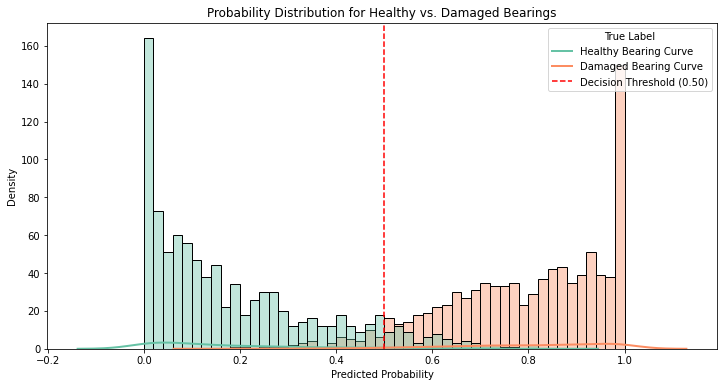

Number of good bearings (0) in the test set: 919
Number of damaged bearings (1) in the test set: 924


Time Metrics:
Average Pre-processing Time: 0.0074 seconds
Inference Time: 0.0531 seconds
Average Inference Time: 2.8816824430236983e-05 seconds


Accuracy: 0.9354
Precision: 0.9259
Recall: 0.9470
F1 Score: 0.9363
ROC AUC: 0.9843
Test Loss: 0.2461


Classification Report:
              precision    recall  f1-score   support

     DAMAGED       0.95      0.92      0.93       919
     HEALTHY       0.93      0.95      0.94       924

    accuracy                           0.94      1843
   macro avg       0.94      0.94      0.94      1843
weighted avg       0.94      0.94      0.94      1843



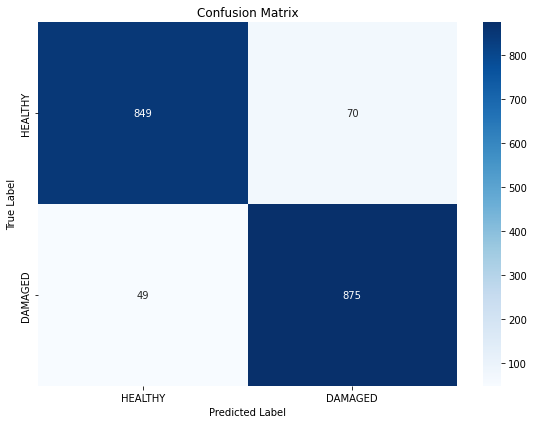

Label \ Pred,0,1
0,849,49
1,70,875


In [3]:
import config

if(config.smote):
    # Oversampling the train dataset using SMOTE
    smt = SMOTE()
    features_df, labels_df = smt.fit_resample(features_df, labels_df)
    # Combine features and labels into one DataFrame
    data = pd.concat([features_df, labels_df], axis=1)
    
elif(config.force_balanced_dataset):
    
    # Combine features and labels into one DataFrame
    df = pd.concat([features_df, labels_df], axis=1)        
    
    # Split the dataframe based on the binary labels (0 and 1)
    df_class_0 = df[df['label'] == 0]
    df_class_1 = df[df['label'] == 1]

    # Find the minimum size between the two classes
    min_size = min(len(df_class_0), len(df_class_1))

    # Truncate both classes to the same size
    df_class_0_balanced = df_class_0.sample(n=min_size, random_state=52)
    df_class_1_balanced = df_class_1.sample(n=min_size, random_state=52)

    # Combine the balanced classes
    df_balanced = pd.concat([df_class_0_balanced, df_class_1_balanced])

    # Shuffle the dataframe (optional)
    data = df_balanced.sample(frac=1, random_state=53).reset_index(drop=True)
    
else:
    # Combine features and labels into one DataFrame
    data = pd.concat([features_df, labels_df], axis=1)


print(f"Data Shape: {data.shape}")

# Data Splitting
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

if(config.model['GBDT']):
    metrics_folder = 'GBDT'
    model_string = 'gbdt'
    model_save_folder = os.path.join(current_dir, "DTs_Models", 'IMPROVED_DATASET', metrics_folder)
    model_name = model_string + '_' + methods_string
    model_save_path = os.path.join(model_save_folder, model_name)
    if(config.model_load and os.path.exists(model_save_path)):
        print("Model already exists")
        model = ydf.load_model(model_save_path)
    else:
        clf = ydf.GradientBoostedTreesLearner(
            label='label',
            task=ydf.Task.CLASSIFICATION, 
            num_trees=config.model_params_GBDT['num_trees'], 
            growing_strategy=config.model_params_GBDT['growing_strategy'], 
            max_depth=config.model_params_GBDT['max_depth'],
            early_stopping=config.model_params_GBDT['early_stopping'],
            validation_ratio=0.1,
            split_axis=config.model_params_GBDT['split_axis'],
            # Train every model with 1.0 (sparse_oblique_num_projections_exponent). The better retrain with 2.0
            sparse_oblique_num_projections_exponent=config.model_params_GBDT['sparse_oblique_num_projections_exponent'],
            max_num_nodes=50,
            l1_regularization=config.model_params_GBDT['l1_regularization'],
            l2_regularization=config.model_params_GBDT['l2_regularization'],
            shrinkage = config.model_params_GBDT['shrinkage']
        )
        
        # List the available templates for the GBDT learner.
        #templates = clf.hyperparameter_templates()
        #print(templates)
        model = clf.train(X_train, verbose=2)
        print("\nValidation Results:")
        val_results = model.validation_evaluation()        
        print(val_results)
        # Plot a tree
        model.print_tree(tree_idx=0)

        if(config.save_model and not os.path.exists(model_save_path)):
            os.makedirs(model_save_folder, exist_ok=True)
            model.save(model_save_path)
            
elif(config.model['RF']):
    metrics_folder = 'RF'
    model_string = 'rf'
    model_save_folder = os.path.join(current_dir, "DTs_Models", metrics_folder)
    model_name = model_string + '_' + methods_string
    model_save_path = os.path.join(model_save_folder, model_name)
    if(config.model_load and os.path.exists(model_save_path)):
        print("Model already exists")
        model = ydf.load_model(model_save_path)
    else:
        clf = ydf.RandomForestLearner(
            label='label',
            task=ydf.Task.CLASSIFICATION, 
            num_trees=config.model_params_RF['num_trees'], 
            growing_strategy=config.model_params_RF['growing_strategy'], 
            max_depth=config.model_params_RF['max_depth'],
            split_axis=config.model_params_RF['split_axis'],
            # Train every model with 1.0 (sparse_oblique_num_projections_exponent). The better retrain with 2.0
            sparse_oblique_num_projections_exponent=config.model_params_RF['sparse_oblique_num_projections_exponent'],
            winner_take_all=config.model_params_RF['winner_take_all'],
            max_num_nodes=config.model_params_RF['max_num_nodes']     
        )
        
        # List the available templates for the GBT learner.
        templates = clf.hyperparameter_templates()
        print(templates)
            
        model = clf.train(X_train, verbose=1)
        
        # As the Random Forest model does not require a validation set, we will use the out-of-bag evaluations
        print("\nOut of_bag evaluations:")
        val_results = model.out_of_bag_evaluations()        
        print(val_results)
        # Plot a tree
        model.print_tree(tree_idx=0)

        if(config.save_model and not os.path.exists(model_save_path)):
            os.makedirs(model_save_folder, exist_ok=True)
            model.save(model_save_path)           

# Get the HTML content from model.describe()
html_content = model.describe(output_format='html')

if(config.save_html):
    # Save it to an HTML file
    with open(model_string + '_' + methods_string + '.html', 'w') as f:
        f.write(html_content)            

if(model_string == 'gbdt'):
    save_path_loss = os.path.join(current_dir, 'tuning_loss', model_string + '_' + methods_string + '.svg')
    os.makedirs(save_path_loss, exist_ok=True)
    plot_from_html(html_content, save = False, save_path=save_path_loss)
perform_evaluation_and_prediction(model, X_test, metrics_folder, model_string, data, average_pre_proc_time, methods_string, clf)
            

In [4]:
model.describe()

